<a href="https://colab.research.google.com/github/doantronghieu/DEEP-LEARNING/blob/main/CSR_TF_Dev_Pro_Cert/C4/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers, optimizers, losses, models, callbacks, metrics
import seaborn as sns
sns.set()

In [2]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

def trend(time, slope = 0):
    return (slope * time)

def seasonal_pattern(season_time):
    """ Just an arbitrary pattern, you can change it if you wish """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """ Repeats the same pattern at each period """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time        = np.arange(4 * 365 + 1, dtype = "float32")
series      = trend(time, slope = 0.1)  
baseline    = 10
amplitude   = 40
slope       = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train    = series[:split_time]
x_valid    = series[split_time:]

window_size         = 20
batch_size          = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 128,
                             shuffle_buffer = shuffle_buffer_size)

model = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    layers.SimpleRNN(40, return_sequences = True),
    layers.SimpleRNN(40),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                           
])

lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

model.compile(loss = losses.Huber(),
              optimizer = optimizers.SGD(learning_rate = 1e-8, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule], verbose = 0)

Epoch 1/100
8/8 [==============================] - 4s 74ms/step - loss: 195.5727 - mae: 196.0727 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 194.7820 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 193.5110 - mae: 194.0110 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 32ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 187.8583 - mae: 188.3583 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 185.3787 - mae: 185.8787 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 182.5484 - mae: 183.0484 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 179.3126 - mae: 

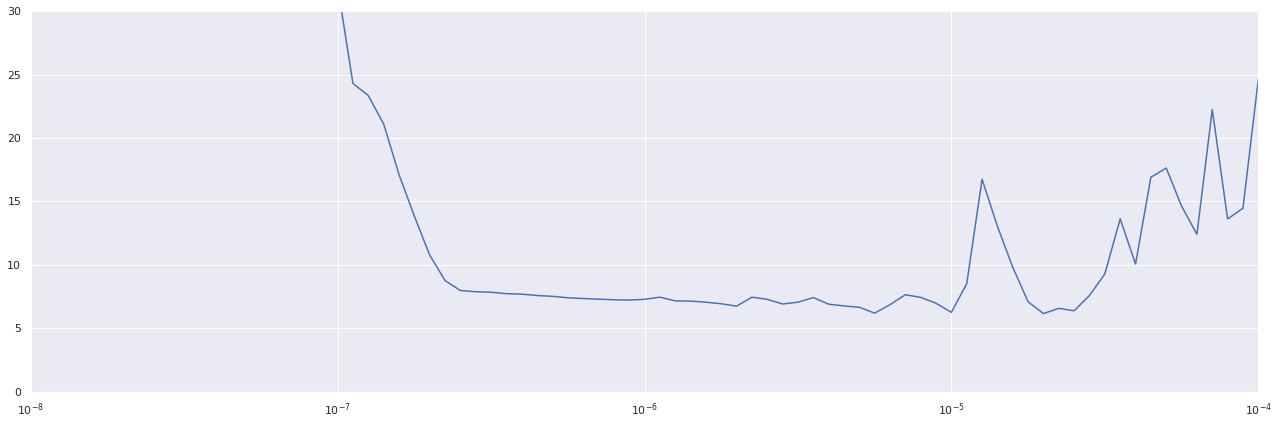

In [13]:
plt.figure(figsize = (22, 7))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 128,
                             shuffle_buffer = shuffle_buffer_size)

model = models.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    layers.SimpleRNN(40, return_sequences = True),
    layers.SimpleRNN(40),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                           
])

model.compile(loss = losses.Huber(),
              optimizer = optimizers.SGD(learning_rate = 5e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 400, verbose = 0)

Error: 6.781694412231445


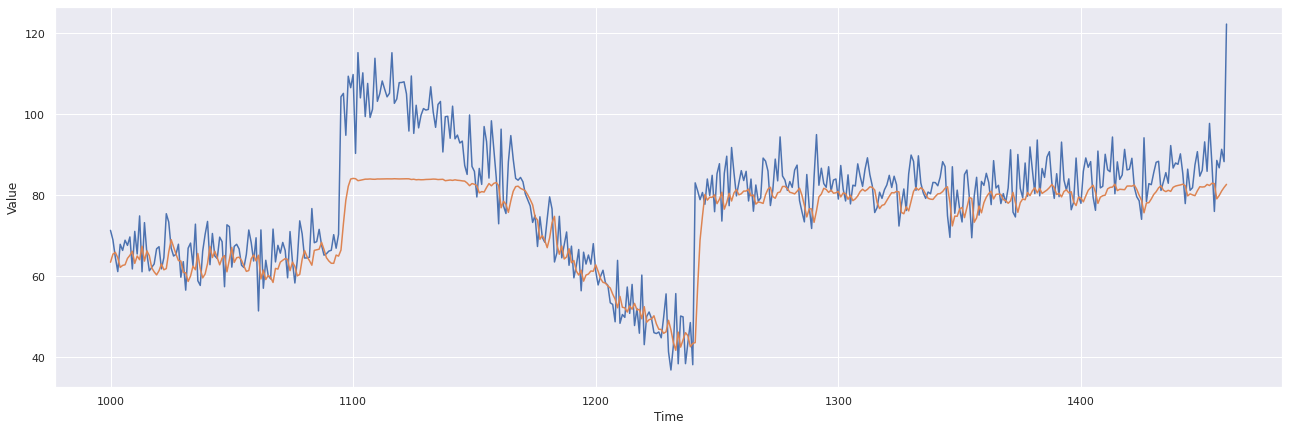

In [17]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results  = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (22, 7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(f'Error: {metrics.mean_absolute_error(x_valid, results).numpy()}')

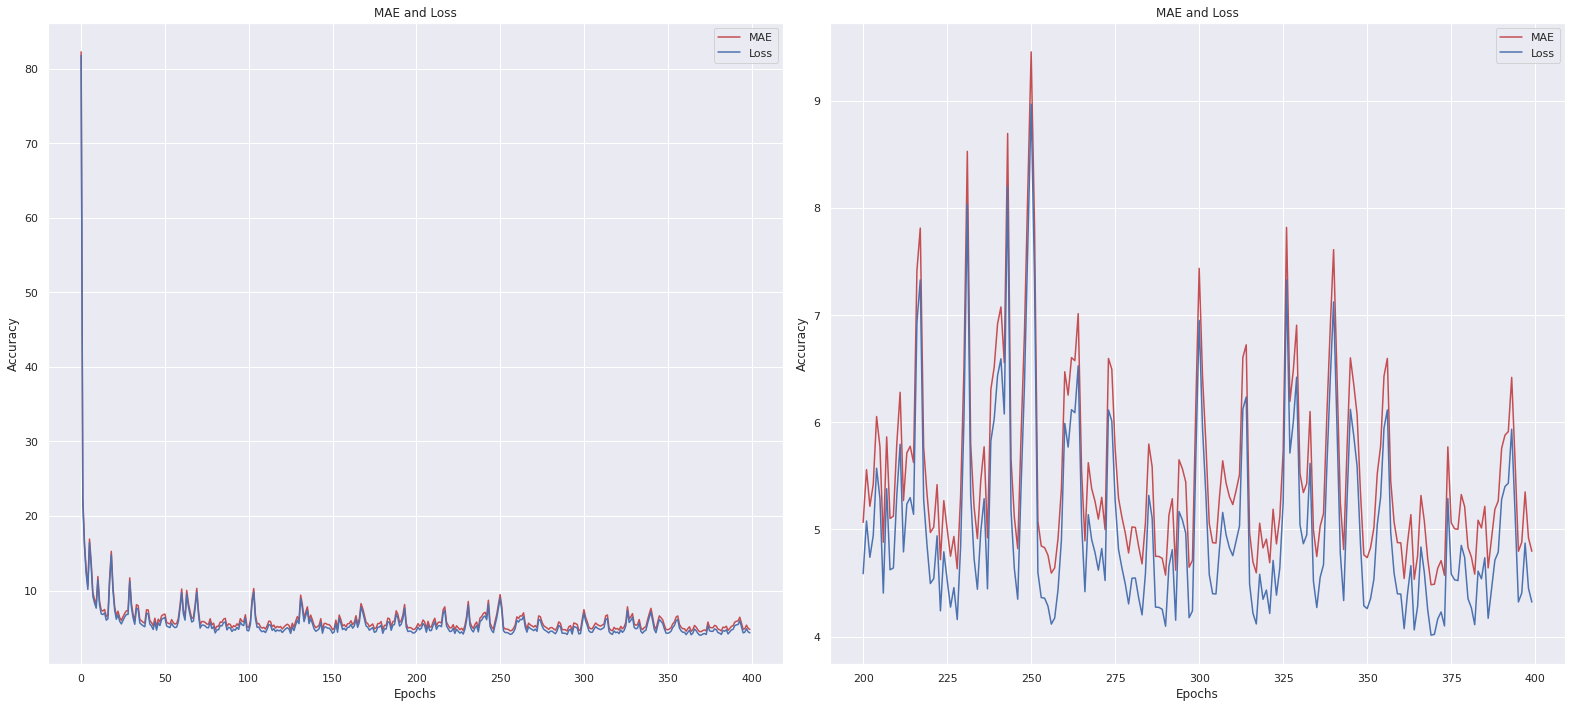

In [22]:
# - Retrieve a list of results on training and test data sets for each 
# training epoch
mae  = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss)) # Number of epochs

epochs_zoom = epochs[200:]
mae_zoom    = mae[200:]
loss_zoom   = loss[200:]

fig, axs = plt.subplots(1, 2, figsize = (22, 10))

axs[0].plot(epochs, mae, 'r', label = 'MAE')
axs[0].plot(epochs, loss, 'b', label = 'Loss')
axs[0].set(xlabel = 'Epochs', ylabel = 'Accuracy', title = 'MAE and Loss')
axs[0].legend()

axs[1].plot(epochs_zoom, mae_zoom, 'r', label = 'MAE')
axs[1].plot(epochs_zoom, loss_zoom, 'b', label = 'Loss')
axs[1].set(xlabel = 'Epochs', ylabel = 'Accuracy', title = 'MAE and Loss')
axs[1].legend()

plt.tight_layout()
plt.show()